In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from collections import Counter
import re

from tamil import utf8
from indicnlp import common
from indicnlp import loader
from indicnlp.tokenize import indic_tokenize
from indicnlp.transliterate.unicode_transliterate import ItransTransliterator

# Export the path to the Indic NLP Resources directory programmatically
INDIC_NLP_RESOURCES=r"./indic_nlp_resources/"
common.set_resources_path(INDIC_NLP_RESOURCES)

# Initialize the Indic NLP library
loader.load()

# Exploring the Data

In [29]:
df_tamil_eda = pd.read_csv("./tamilmurasu_data/tamil_news_cleaned.csv", encoding='utf-8')
df_tamil_eda.head()

,news_id,news_date,news_category,news_title,news_article
0,6,1/6/2011 2:45:49 PM,மர்மம்,தூக்கில் தொங்கும் சேவல்கள் திருடர்களை காவு வாங...,"நாலு ஆள் உயரம் , முறுக்கு மீசை , கையில் வீச்சர..."
1,9,1/6/2011 2:56:51 PM,மர்மம்,பவுர்ணமி ஜாமத்தில் மாயமான கர்ப்பிணி,அமானுஷ்யமான சம்பவங்கள் நம்மை சுற்றி ஆங்காங்கே ...
2,10,1/6/2011 3:02:00 PM,இந்தியா,காமன்வெல்த் ஊழல் : சுரேஷ் கல்மாடியிடம் 102 கேள...,காமன்வெல்த் போட்டி ஏற்பாட்டில் நடைபெற்ற முறைகே...
3,11,1/6/2011 3:08:15 PM,மர்மம்,மச்சுபிச்சு மலை ரகசியம்,தென்அமெரிக்க நாடான பெருவில் காடுகள் பயங்கரமானவ...
4,12,1/6/2011 3:09:20 PM,மர்மம்,ரத்த பலி வாங்கும் விபரீத ஆவி !,கடந்த 18ம் தேதி சாயங்காலம் . . . அடைமழையை கிழி...


In [42]:
import seaborn as sns
import pandasql as ps

categories_df = ps.sqldf("select news_category , count(news_category) as Count from df_tamil_eda group by news_category")
categories_df['Translation'] = ['Spirituality' , 'India' , 'World' , 'Education' , 'Crime' , 'Cinema' , 'Tamil Nadu' , 'Editorial' , 'Occupation' ,
                                'Medicine' , 'Mystery' , 'District Masala' , 'Sports' , 'Employment' , 'State Express']
categories_df

,news_category,Count,Translation
0,ஆன்மீகம்,406,Spirituality
1,இந்தியா,16935,India
2,உலகம்,7477,World
3,கல்வி,240,Education
4,குற்றம்,16290,Crime
5,சினிமா(ரீல்மா),9248,Cinema
6,தமிழகம்,53333,Tamil Nadu
7,தலையங்கம்,1535,Editorial
8,தொழில்,68,Occupation
9,மருத்துவம்,544,Medicine


Text(0.5, 1.0, 'Category-wise analysis')

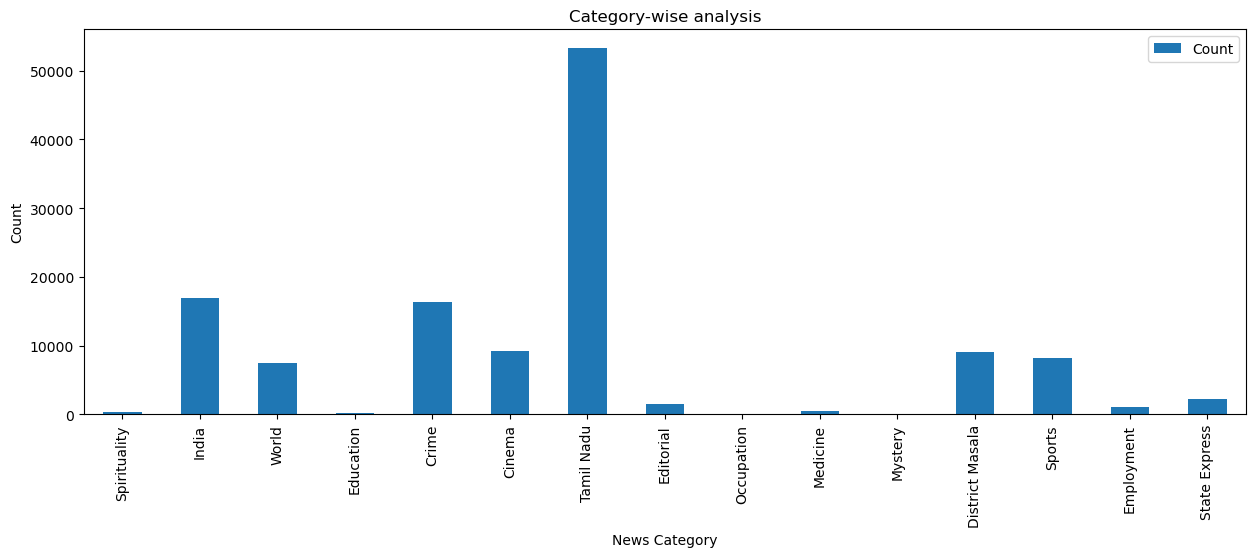

In [43]:
def barplot_categories(categories_df):
    plot = categories_df.plot.bar(x='Translation', y='Count', figsize=(15, 5))
    plot.set_xlabel('News Category')
    plot.set_ylabel('Count')
    plot.set_title('Category-wise analysis')

barplot_categories(categories_df)

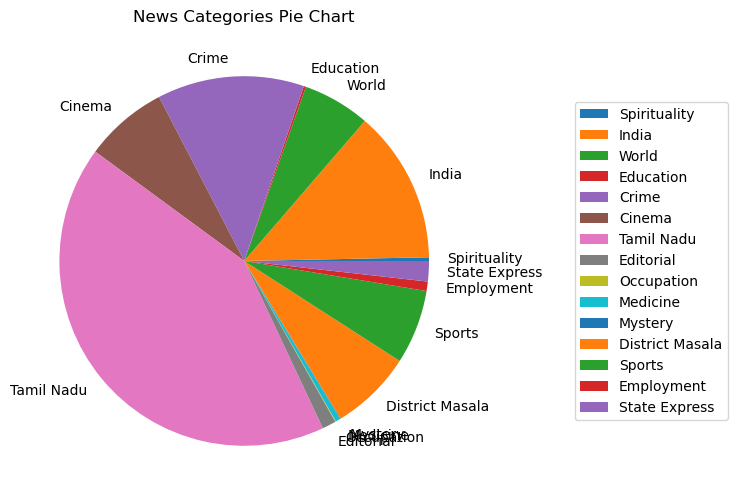

In [60]:
df piechart_categories(categories_df):
    labels = categories_df['Translation']
    sizes = categories_df['Count']
    # Create a pie chart
    plt.figure(figsize=(6, 6))  # Optional: Set the figure size
    plt.pie(sizes , labels=labels)
    
    plt.title('News Categories Pie Chart')
    
    plt.legend(labels, loc="center left", bbox_to_anchor=(1.2, 0.5))
    
    plt.show()

# Working On the Model ...

## Preprocessing used

In [2]:
def preprocess_tamil_text(corpus):
    # look at morphing tamil words for a better run
    
    # https://gist.github.com/arulrajnet/e82a5a331f78a5cc9b6d372df13a919c
    # removing stop words from the articles
    stop_words_tamil = [u"அங்கு",u"அங்கே",u"அடுத்த",u"அதற்கு",u"அதனால்",u"அதன்",u"அதிக",u"அதில்",u"அது",u"அதே",u"அதை",u"அந்த",u"அந்தக்",u"அந்தப்",u"அல்லது",u"அவரது",u"அவர்",u"அவர்கள்",u"அவள்",u"அவன்",u"அவை",u"அன்று",u"ஆகிய",u"ஆகியோர்",u"ஆகும்",u"ஆனால்",u"இங்கு",u"இங்கே",u"இடத்தில்",u"இடம்",u"இதற்கு",u"இதனால்",u"இதனை",u"இதன்",u"இதில்",u"இது",u"இதை",u"இந்த",u"இந்தக்",u"இந்தத்",u"இந்தப்",u"இப்போது",u"இரு",u"இருக்கும்",u"இருந்த",u"இருந்தது",u"இருந்து",u"இல்லை",u"இவர்",u"இவை",u"இன்னும்",u"உள்ள",u"உள்ளது",u"உள்ளன",u"உன்",u"எந்த",u"எல்லாம்",u"என",u"எனக்",u"எனக்கு",u"எனப்படும்",u"எனவும்",u"எனவே",u"எனினும்",u"எனும்",u"என்",u"என்பது",u"என்பதை",u"என்ற",u"என்று",u"என்றும்",u"என்ன",u"என்னும்",u"ஏன்",u"ஒரு",u"ஒரே",u"ஓர்",u"கொண்ட",u"கொண்டு",u"கொள்ள",u"சற்று",u"சில",u"சிறு",u"சேர்ந்த",u"தவிர",u"தனது",u"தன்",u"தான்",u"நாம்",u"நான்",u"நீ",u"பல",u"பலரும்",u"பல்வேறு",u"பற்றி",u"பற்றிய",u"பிற",u"பிறகு",u"பின்",u"பின்னர்",u"பெரும்",u"பேர்",u"போது",u"போல",u"போல்",u"போன்ற",u"மட்டுமே",u"மட்டும்",u"மற்ற",u"மற்றும்",u"மிக",u"மிகவும்",u"மீது",u"முதல்",u"முறை",u"மேலும்",u"மேல்",u"யார்",u"வந்த",u"வந்து",u"வரும்",u"வரை",u"வரையில்",u"விட",u"விட்டு",u"வேண்டும்",u"வேறு"]
    
    cleaned_article = ''
    
    # removing stopwords from corpus
    for article_token in indic_tokenize.trivial_tokenize(corpus):
        if article_token not in stop_words_tamil:
            cleaned_article += (' ' + article_token)
    
    pattern = r"[\xa0.,?!:/@#$%^&*(){}<>-_\+=\[\]\d’‘\"'\\]"  # Matches symbols and digits \xa0
    cleaned_article = re.sub(pattern, '', cleaned_article)
    return cleaned_article

## Reading the Cleaned Data

In [3]:
df_tamil = pd.read_csv("./tamilmurasu_data/tamil_news_cleaned.csv", encoding='utf-8')
df_tamil.sample(5)

,news_id,news_date,news_category,news_title,news_article
35096,35524,10/29/2012 12:12:11 PM,தமிழகம்,காவல் துறைக்கு உதவும் வகையில் துணை படை : ஜெயலல...,சென்னை : சட்டம் ஒழுங்கை பராமரிக்கவும் குற்றங்க...
18056,18305,12/17/2011 1:55:31 PM,மாவட்ட மசாலா,அமோக விளைச்சல் தக்காளி விலை வீழ்ச்சி,ஒகேனக்கல் : தர்மபுரி மாவட்டம் பென்னாகரம் பகுதி...
13662,13866,9/26/2011 11:39:51 AM,தலையங்கம்,உதவ மறுத்த உறவுகள் !,"குடும்பத்தில் பிரச்னை வரும்போது , விலகி நின்று..."
8696,8849,6/20/2011 3:25:48 PM,இந்தியா,கனிமொழி ஜாமீன் மனு சுப்ரீம் கோர்ட் நிராகரிப்பு !,புதுடெல்லி : ஸ்பெக்ட்ரம் வழக்கில் கைது செய்யப்...
77517,78242,7/17/2015 2:36:16 PM,குற்றம்,பெற்றோர்கள் எதிர்ப்பு காரணமாக பூச்சி மருந்து க...,பொன்னேரி : பெற்றோர் எதிர்ப்பு தெரிவித்ததால் பூ...


## Making all words/sentences lists

In [4]:
# storing as
# [ [article1] , [article2]  ... ]
# and removing unwanted symbols/digits as well 

articles_sentences_combined = []
for i in tqdm( range(len(df_tamil)) ):
    articles_sentences_combined.append(preprocess_tamil_text(df_tamil['news_article'][i]))

In [5]:
print(articles_sentences_combined[3944])

 திண்டுக்கல்  ஆத்தூர் தொகுதி தேமுதிக வேட்பாளர் பாலசுப்பிரமணி நேற்று வேட்புமனு தாக்கல் செய்ய திண்டுக்கல் கலெக்டர் ஆபீசுக்கு வந்தார்  அவரிடம் உச்சகட்ட பரபரப்பு  அதிமுக மாவட்ட செயலாளர் நத்தம் விசுவநாதன்  மாவட்ட அவைத்தலைவர் சீனிவாசனும் உடன் வந்தனர்  வாட்ச்சை திருப்பி திருப்பி பார்த்துக் கொண்டே தேர்தல் அதிகாரி முருகவேலின் அறைக்குள் ஓடினார் பாலசுப்பிரமணி  வாங்கிப் பார்த்த அதிகாரிக்கு அதிர்ச்சி  என்னங்க   வெறும் படிவத்தை கொடுக்கறீங்க  நிரப்பவில்லையா   என்றார்  ஒரு மணி வரைதான் நல்ல நேரம்னாங்க  மொதல்ல வாங்கிடுங்க  அப்புறம் நிரப்புறேன் என்றார் பாலசுப்பிரமணி  நிரப்பாத படிவத்தை வாங்க முடியாது கறாராக கூறிவிட்டார் அதிகாரி  வாசல் பகுதியில் அறைக்கு சென்றனர்  பூர்த்தி செய்ய மணி நேரம் ஆனது  தாக்கல் செய்துவிட்டு சென்றார்  http    election  dinakaran  com 


# Need to perform stemming/morphological analysis on these words too

In [6]:
from indicnlp.morph import unsupervised_morph 

tamil_morphanalyzer = unsupervised_morph.UnsupervisedMorphAnalyzer('ta')

## Getting Stemmed Articles to reduce vocabulary and hence reduced dimensions

In [9]:
tamil_articles_stemmed = []

for article in tqdm(articles_sentences_combined):
    analyzes_tokens = tamil_morphanalyzer.morph_analyze_document(article.split(' '))
    stemmed_tamil_sentence = " ".join(analyzes_tokens)
    tamil_articles_stemmed.append(preprocess_tamil_text(stemmed_tamil_sentence))

In [11]:
# storing vocabulary by removing repeated words

tamil_repeating_vocab = []
for i,cur_article in tqdm( enumerate(tamil_articles_stemmed) ):
    cur_words = cur_article.split()
    tamil_repeating_vocab.extend(cur_words)

tamil_vocab = list(set(tamil_repeating_vocab))

print("Vocabulary Length" , len(tamil_vocab))

126746it [00:04, 29193.79it/s]


Vocabulary Length 71732


# Converting data into vectors using different methods

## using CountVectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# trying sklearn countvectorizer on tamil dataset
bag_tamil_words = CountVectorizer()
tamil_count_vecs = bag_tamil_words.fit_transform(tamil_articles_stemmed).toarray()

In [30]:
print(bag_tamil_words.get_feature_names_out())
# print(sum(list(tamil_count_vecs[223])))
tamil_count_vecs

['aaaoe' 'aai' 'aaisite' ... 'ஹஷ' 'ஹஸ' 'ஹஸன']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## using TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# trying sklearn TfidfVectorizer on tamil dataset
tfidf_tamil_words = TfidfVectorizer()
tamil_tfidf_vecs = tfidf_tamil_words.fit_transform(tamil_articles_stemmed).toarray()

In [38]:
print("All words identified by TFIDF" , tfidf_tamil_words.get_feature_names_out() , len(tfidf_tamil_words.get_feature_names_out()))
print("Number of Dimensions" , len(tamil_tfidf_vecs[1]) )

All words identified by TFIDF ['aaaoe' 'aai' 'aaisite' ... 'ஹஷ' 'ஹஸ' 'ஹஸன'] 7208
Number of Dimensions 7208


# Training Models

In [39]:
# encoding the unique categories

from sklearn.preprocessing import LabelEncoder

# tamil news categories
categories = list(df_tamil['news_category'])

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
target_vectors = label_encoder.fit_transform(categories)

print("Encoded Categories:", target_vectors)
print("Category Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Encoded Categories: [10 10  1 ...  6  6  4]
Category Mapping: {'ஆன்மீகம்': 0, 'இந்தியா': 1, 'உலகம்': 2, 'கல்வி': 3, 'குற்றம்': 4, 'சினிமா(ரீல்மா)': 5, 'தமிழகம்': 6, 'தலையங்கம்': 7, 'தொழில்': 8, 'மருத்துவம்': 9, 'மர்மம்': 10, 'மாவட்ட மசாலா': 11, 'விளையாட்டு': 12, 'வேலைவாய்ப்பு': 13, 'ஸ்டேட் எக்ஸ்பிரஸ்': 14}


## Applying SVD to reduce dimensions

In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=700, random_state=42)
tamil_tfidf_vecs_svd = svd.fit_transform(tamil_tfidf_vecs)

## Splitting into training and testing set

In [21]:
from sklearn.model_selection import train_test_split
from random import random

# Split data into train/test with CountVectorizer vectors
# X_train_CountVec, X_test_CountVec, y_train, y_test = train_test_split(tamil_count_vecs, target_vectors, test_size=0.2, random_state=42)

# Split data into train/test with TFIDF vectors
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(tamil_tfidf_vecs_svd, target_vectors, test_size=0.2, random_state=42)

# Applying SMOTE for Oversampling Minority Sets

In [74]:
# finding a just sampling strategy for oversampling

print(Counter(y_train))

articles_sampling_strategy = {
    6: 42679,
    1: 13527,
    4: 13003,
    5: 7402,
    11: 7316,
    12: 6608,
    2: 5940,
    14: 3000,
    7: 3000,
    13: 3000,
    9: 3000,
    0: 3000,
    3: 3000,
    10: 3000,
    8: 3000
}

Counter({6: 42679, 1: 13527, 4: 13003, 5: 7402, 11: 7316, 12: 6608, 2: 5940, 14: 1804, 7: 1210, 13: 846, 9: 438, 0: 335, 3: 186, 10: 51, 8: 51})


In [75]:
from imblearn.over_sampling import SMOTE

oversampling_model = SMOTE(sampling_strategy=articles_sampling_strategy , random_state=42)

X_test_TFIDF_smote , y_train_smote = oversampling_model.fit_resample(X_train_TFIDF, y_train)

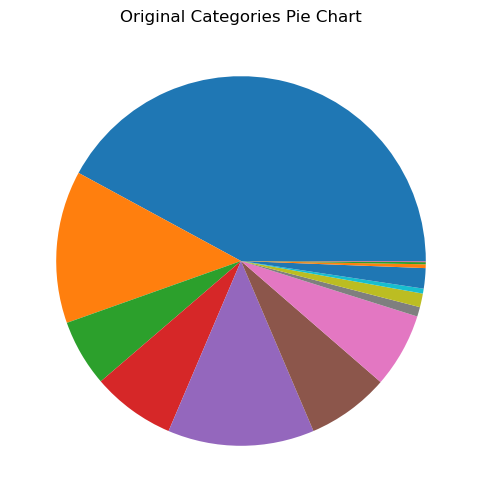

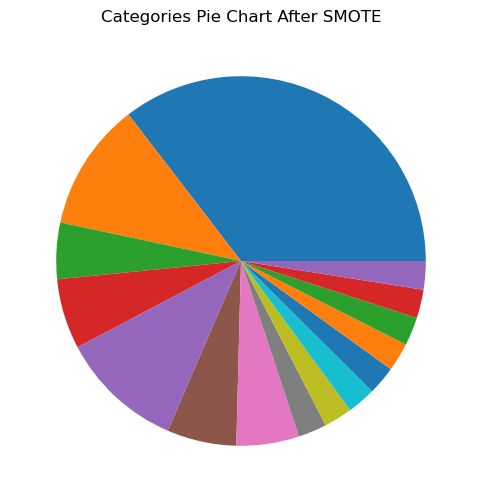

In [76]:
def piechart_categories(counts , text):
    sizes = counts
    # Create a pie chart
    plt.figure(figsize=(6, 6))  # Optional: Set the figure size
    plt.pie(sizes)
    
    plt.title(text)
    
    plt.show()

piechart_categories(list(Counter(y_train).values()) , 'Original Categories Pie Chart')
piechart_categories(list(Counter(y_train_smote).values()) , 'Categories Pie Chart After SMOTE')

## Training Using Only Probabilities of Categories

In [77]:
# using only Probabilities from training data without any model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from random import random

# using only training data to get probabilities

# getting counts for all categories
_ , counts = np.unique(y_train_smote, return_counts=True)

# calculating probabilities
probabilities_train = [x/sum(counts) for x in counts]

# getting cumulative freq
probabilities_train_cumulative = [ sum(probabilities_train[:i+1]) for i in range(len(probabilities_train)) ]
# print(probabilities_train_cumulative)

# Predictions based on probabilities
y_pred = []
for i in range(len(y_test)):
    randval = random()
    y_pred.append(np.searchsorted(probabilities_train_cumulative, randval))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.19570019723865878
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.04      0.01        71
           1       0.13      0.11      0.12      3408
           2       0.05      0.04      0.05      1537
           3       0.01      0.06      0.01        54
           4       0.13      0.10      0.11      3287
           5       0.07      0.06      0.06      1846
           6       0.42      0.36      0.39     10654
           7       0.01      0.02      0.01       325
           8       0.00      0.00      0.00        17
           9       0.01      0.06      0.02       106
          10       0.00      0.07      0.00        15
          11       0.07      0.06      0.07      1763
          12       0.07      0.06      0.06      1622
          13       0.01      0.03      0.01       196
          14       0.03      0.04      0.03       449

    accuracy                           0.20     25350
   macro avg       0.07   

# training a Multinomial NaiveBayes Classifier using TFIDF Vecs

In [59]:
# training a MultinomialNB model using TF IDF vecs (doesnt take -ve values)

from sklearn.naive_bayes import MultinomialNB

model4 = MultinomialNB()
model4.fit(X_train_TFIDF, y_train)

# Evaluate the model
y_pred = model4.predict(X_test_TFIDF)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ValueError: Negative values in data passed to MultinomialNB (input X)

# training a LogisticRegression model using TF IDF vecs

In [82]:
# training a LogisticRegression model using TF IDF vecs

from sklearn.linear_model import LogisticRegression

# Train a model
model2 = LogisticRegression(random_state=42)
model2.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = model2.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.70232741617357
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.39      0.16        71
           1       0.67      0.62      0.64      3408
           2       0.64      0.56      0.60      1537
           3       0.30      0.72      0.43        54
           4       0.63      0.66      0.64      3287
           5       0.93      0.92      0.92      1846
           6       0.71      0.83      0.77     10654
           7       0.40      0.40      0.40       325
           8       0.20      0.82      0.32        17
           9       0.77      0.93      0.85       106
          10       0.07      0.67      0.12        15
          11       0.46      0.08      0.13      1763
          12       0.93      0.92      0.93      1622
          13       0.93      0.97      0.95       196
          14       0.34      0.09      0.15       449

    accuracy                           0.70     25350
   macro avg       0.54      

C:\Users\Ojasva Saxena\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
from sklearn.svm import SVC  # Support Vector Classifier

# Train a model
model3 = SVC(kernel='linear', C=1.0, random_state=42)
model3.fit(X_test_TFIDF_smote, y_train_smote)

# Evaluate the model
y_pred = model3.predict(X_test_TFIDF)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.713491124260355
Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.51      0.21        71
           1       0.67      0.64      0.66      3408
           2       0.67      0.57      0.61      1537
           3       0.37      0.76      0.49        54
           4       0.62      0.71      0.66      3287
           5       0.93      0.93      0.93      1846
           6       0.72      0.84      0.77     10654
           7       0.49      0.39      0.43       325
           8       0.33      0.82      0.47        17
           9       0.85      0.93      0.89       106
          10       0.16      0.60      0.25        15
          11       0.00      0.00      0.00      1763
          12       0.94      0.93      0.93      1622
          13       0.95      0.97      0.96       196
          14       0.00      0.00      0.00       449

    accuracy                           0.71     25350
   macro avg       0.52     

C:\Users\Ojasva Saxena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ojasva Saxena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ojasva Saxena\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# training a LogisticRegression model using CountVectorizer vecs

In [30]:
# training a LogisticRegression model using CountVectorizer vecs

from sklearn.linear_model import LogisticRegression

# Train a model
model1 = LogisticRegression()
model1.fit(X_train_CountVec, y_train)

# Evaluate the model
y_pred = model1.predict(X_test_CountVec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

NameError: name 'X_train_CountVec' is not defined

## Saving the better model

In [83]:
import joblib

joblib.dump(model2, "model3.pkl") 

['model3.pkl']

# Trying out the model 

In [84]:
# taken from https://www.dinamalar.com/news/tamil-nadu-news/tasmac-federation-warns-dmk-of-protest-if-it-does-not-stop-intimidating-employees-/3782157
# latest_news = "தஞ்சாவூர் : தஞ்சாவூரில், டாஸ்மாக் ஊழியர் சம்மேளனத்தின், மாநில குழு கூட்டம் நேற்று நடந்தது. இதில், பங்கேற்ற அச்சங்கத்தின் மாநில பொதுச்செயலர் திருச்செல்வன் கூறியதாவது: பணி நிரந்தரம், அரசு ஊழியர்களுக்கு இணையான ஊதியம் உள்ளிட்ட கோரிக்கைகளை, 20 ஆண்டுகளாக ஆட்சியாளர்களிடம் வலியுறுத்தி வருகிறோம். ஆனால், அ.தி.மு.க.,வும் நிறைவேற்றவில்லை; ஆளும் தி.மு.க.,வும் பரிசீலனையில் எடுத்துக் கொள்ளவில்லை. இந்த அரசுக்கு, எங்கள் கோரிக்கைகளை பலமுறை கொண்டு சென்றும், நிறைவேற்ற மறுக்கிறது. முதல்வர் சட்டசபை தேர்தலின் போது, தமிழகத்தில், மதுவிலக்கை படிப்படியாக அமல்படுத்துவோம் என, மக்களிடையே வாக்குறுதி அளித்தார். ஆட்சிப் பொறுப்பேற்றதும், 500 டாஸ்மாக் கடைகளை மூடியதை வரவேற்கிறோம். ஆனால், அரசு கடைகளை மூடிவிட்டு, தனியாருக்கு மனமகிழ்மன்றம் என்ற வகையில் உரிமம் வழங்கப்பட்டு வருகிறது. அதாவது, அரசு செய்யும் வியாபாரத்தை தனியாருக்கு மடை மாற்றும் போக்கு நடைபெறுகிறது. கணினி ரசீது முறை அமல்படுத்தப்பட்டு உள்ளதாக, டாஸ்மாக் நிர்வாகம் அறிவித்துள்ளது. இதிலும், பல பிரச்னைகளை ஊழியர்கள் சந்திப்பதால், மன அழுத்தத்துக்கு ஆளாகின்றனர். டாஸ்மாக் நிறுவனத்தில் பணியிட மாற்றம், பணி நியமனத்தில் பல்வேறு முறைகேடுகள் நடக்கின்றன. ஆளுங்கட்சி தலையீடு இருக்கிறது. டாஸ்மாக் கடை ஊழியர்களை ஆளுங்கட்சியினர் மிரட்டி, மாமூல் வசூலிக்கும் போக்கு, அரசுக்கு அவப்பெயரை ஏற்படுத்தும். இவர்கள் மீது தி.மு.க., தலைமை கடும் நடவடிக்கை எடுக்க வேண்டும். இல்லாவிட்டால் ஊழியர்கள் போராட்டத்தில் ஈடுபடுவர். இவ்வாறு அவர் கூறினார்."

## ------------------------------------------------------ ##

# taken from https://tamil.samayam.com/latest-news/international-news/iran-supreme-leader-ali-khamenei-says-about-does-he-plan-to-assassinate-donald-trump/articleshow/115380006.cms?trc_source=TaboolaExploreMore
# latest_news = "அமெரிக்க அதிபர் தேர்தலில் வெற்றி பெற்றுள்ள டொனால்ட் டிரம்பை கொலை செய்ய திட்டமிடவில்லை என ஈரான் உச்சபட்ச தலைவர் அலிகமெனி மறுப்பு தெரிவித்துள்ளார். அமெரிக்க அதிபர் தேர்தலில் முன்னாள் அதிபர் டொனால்ட் டிரம்ப் அபார வெற்றி பெற்றார். அவர் தன்னை எதிர்த்து போட்டியிட்ட துணை அதிபர் கமலா ஹாரிஸை படுதோல்வி அடைய செய்தார். இதையடுத்து டொனால்ட் டிரம்ப் தனது அமைச்சரவையில் உறுப்பினர் சேர்க்கையை தொடங்கிவிட்டார். இதற்கிடையே ஈரானை சேர்ந்த சுலைமான் படுகொலைக்கு டொனால்ட் டிரம்பபை பழிதீர்க்க உள்ள ஈரான் திட்டமிட்டு இருப்பதாக தகவல்கள் வெளியாகின. அதாவது அமெரிக்க அதிபர் பதவியில் டொனால்ட் டிரம்ப் அமருவதற்கு முன்பு அவரை கொலை செய்ய ஈரான் ஸ்கெட்ச் போட்டு இருப்பதாக கூறப்பட்டது. இது பரபரப்பை ஏற்படுத்தியது. இந்த நிலையில் டொனால்ட் டிரம்பை கொல்ல திட்டம் தீட்டவில்லை என ஈரானின் உச்சபட்ச தலைவர் அலிகமெனி, மறுப்பு தெரிவித்துள்ளார். கடந்த செப்டம்பர் மாதம் ஜோ பைடன் அரசு, டொனால்ட் டிரம்ப் மீது ஏதேனும் தாக்குதல் நடத்தப்பட்டால், போருக்கான அழைப்பாக அது பார்க்கப்படும் என ஈரானை எச்சரித்து இருந்தது."

## ------------------------------------------------------ ##

# taken from https://www.artofliving.org/in-ta/meditation
# latest_news = "தியானத்தின் பலன்கள் பல்வேறு வகையானவை. மன சுத்தமே முதன்மையானது. அமைதியான மனம், நல்ல கவனிப்புத் திறன், கருத்துகளில் தெளிவு, தகவல் தொடர்புகளில் மேம்பாடு, திறன்கள் மற்றும் திறமைகள் மலர்தல், அசைக்க முடியாத உள் திடம், ஆற்றுபடுதல், உள்மன ஆற்றலுடன் இணைதல், இளைப்பாறுதல், புத்துணர்வு பெறுதல், நல்லதிர்ஷ்டம் இவையனைத்தும் ஒழுங்கான சீரான தியானத்தின் இயற்கையான விளைவுகள் ஆகும்."

## ------------------------------------------------------ ##

# taken from https://tamil.oneindia.com/news/chennai/police-close-in-on-sambo-senthil-a2-in-armstrong-murder-case-654935.html
latest_news = "சென்னை: ஆம்ஸ்ட்ராங் கொலை வழக்கில் முக்கிய குற்றவாளியாக கருதப்படும் சம்பவம் செந்தில் என்கிற சம்போ செந்திலின் இருப்பிடத்தை போலீசார் நெருங்கி உள்ளதாக தகவல் வெளியாகியுள்ளது. வெளிநாட்டில் தலைமறைவாக இருக்கும் சம்போ செந்திலின் இருப்பிடத்தை நெருங்கியுள்ள போலீசார், அவரை கைது செய்து சென்னைக்கு அழைத்து வர திட்டமிட்டுள்ளதாக கூறப்படுகிறது. பகுஜன் சமாஜ் கட்சியின் மாநில தலைவராக இருந்த ஆம்ஸ்ட்ராங் கடந்த ஜூலை மாதம் 5ஆம் தேதி பெரம்பூர் செம்பியம் பகுதியில் தனது வீட்டிற்கு வெளியே மர்ம நபர்களால் வெட்டி படுகொலை செய்யப்பட்டார். இந்த கொலைச் சம்பவம் நாடு முழுவதும் பெரும் அதிர்வலைகளை ஏற்படுத்தியது. சிக்கிய ரௌடிகள்: இந்த கொலை வழக்கு தொடர்பாக அரசியல் கட்சி பிரமுகர்கள் மற்றும் வழக்கறிஞர்கள் என மொத்தம் 28 பேர் கைது செய்யப்பட்டனர். ஆம்ஸ்ட்ராங் கொலை தொடர்பாக கைது செய்யப்பட்ட திருவேங்கடம் என்பவர் போலீசாரிடம் இருந்து தப்ப முயன்றதால் சுட்டுக் கொல்லப்பட்டார். அதனை தொடர்ந்து தலைமறைவாக இருந்த சீசிங் ராஜா கைது செய்யப்பட்டு அவரும் என்கவுண்டர் செய்யப்பட்டார். ஆம்ஸ்ட்ராங் கொலை வழக்கில் தலைமறைவாக உள்ள சம்போ செந்தில் மற்றும் வழக்கறிஞர் மொட்டை கிருஷ்ணன் ஆகியோரை தொடர்ந்து போலீசார் தேடி வருகின்றனர். ஆம்ஸ்ட்ராங் கொலை வழக்கில் கைது செய்யப்பட்டுள்ள பொன்னை பாலு, ஆற்காடு சுரேஷின் மனைவி பொற்கொடி, தோட்டம் சேகரின் மனைவி மலர்க்கொடி, ஹரிதரன், சதீஷ்குமார், ஹரிஹரன் சிவா, பிரதீப், முன்னாள் பாஜக நிர்வாகி அஞ்சலை, முகிலன், விஜயகுமார் என்ற விஜய், விக்னேஷ் என்ற அப்பு, முன்னாள் காங்கிரஸ் நிர்வாகியும், பிரபல ரௌடி நாகேந்திரன் மகனுமான அஸ்வத்தாமன், ராஜேஷ், செந்தில்குமார் மற்றும் கோபி உள்ளிட்ட 25 பேர் மீது குண்டர் தடுப்புச் சட்டத்தில் வழக்குப்பதிவு செய்யப்பட்டுள்ளது. ஏ1, ஏ2: ஆம்ஸ்ட்ராங் கொலை வழக்கு தொடர்பாக கைது செய்யப்பட்ட 28 பேரும் மீதும் செம்பியம் காவல்துறையினர் குற்றப்பத்திரிக்கை தாக்கல் செய்தனர். 5000 பக்கங்கள் கொண்ட குற்றப் பத்திரிகையை போலீசார் எழும்பூர் நீதிமன்றத்தில் தாக்கல் செய்துள்ளனர். கைது செய்யப்பட்ட 28 நபர்களோடு சேர்த்து தலைமறைவாக உள்ள சம்போ செந்தில் மற்றும் மொட்டை கிருஷ்ணன் ஆகியோர் மீதும் குற்றப்பத்திரிகை தாக்கல் செய்யப்பட்டுள்ளது."

In [85]:
latest_news_vector = tfidf_tamil_words.transform([preprocess_tamil_text(latest_news)])
latest_news_vector

<1x7208 sparse matrix of type '<class 'numpy.float64'>'
	with 82 stored elements in Compressed Sparse Row format>

In [86]:
clf = joblib.load("model3.pkl")
prediction = clf.predict(latest_news_vector)

ValueError: X has 7208 features, but LogisticRegression is expecting 100 features as input.

In [87]:
print("News Article:")
print(latest_news)
print()
print("Model Prediction")
print(prediction , "i.e." , label_encoder.classes_[prediction])

News Article:
சென்னை: ஆம்ஸ்ட்ராங் கொலை வழக்கில் முக்கிய குற்றவாளியாக கருதப்படும் சம்பவம் செந்தில் என்கிற சம்போ செந்திலின் இருப்பிடத்தை போலீசார் நெருங்கி உள்ளதாக தகவல் வெளியாகியுள்ளது. வெளிநாட்டில் தலைமறைவாக இருக்கும் சம்போ செந்திலின் இருப்பிடத்தை நெருங்கியுள்ள போலீசார், அவரை கைது செய்து சென்னைக்கு அழைத்து வர திட்டமிட்டுள்ளதாக கூறப்படுகிறது. பகுஜன் சமாஜ் கட்சியின் மாநில தலைவராக இருந்த ஆம்ஸ்ட்ராங் கடந்த ஜூலை மாதம் 5ஆம் தேதி பெரம்பூர் செம்பியம் பகுதியில் தனது வீட்டிற்கு வெளியே மர்ம நபர்களால் வெட்டி படுகொலை செய்யப்பட்டார். இந்த கொலைச் சம்பவம் நாடு முழுவதும் பெரும் அதிர்வலைகளை ஏற்படுத்தியது. சிக்கிய ரௌடிகள்: இந்த கொலை வழக்கு தொடர்பாக அரசியல் கட்சி பிரமுகர்கள் மற்றும் வழக்கறிஞர்கள் என மொத்தம் 28 பேர் கைது செய்யப்பட்டனர். ஆம்ஸ்ட்ராங் கொலை தொடர்பாக கைது செய்யப்பட்ட திருவேங்கடம் என்பவர் போலீசாரிடம் இருந்து தப்ப முயன்றதால் சுட்டுக் கொல்லப்பட்டார். அதனை தொடர்ந்து தலைமறைவாக இருந்த சீசிங் ராஜா கைது செய்யப்பட்டு அவரும் என்கவுண்டர் செய்யப்பட்டார். ஆம்ஸ்ட்ராங் கொலை வழக்கில் தலைமறைவாக உள்ள சம்போ செந்தி

NameError: name 'prediction' is not defined